In [1]:
from eaaw_graphlime_utils import *
from transform_functions import *
from config import *

import copy
import matplotlib.pyplot as plt
from   matplotlib.animation import FuncAnimation
import os
from   IPython.display import HTML
import networkx as nx
import numpy as np
import random 
import scipy
import torch
from   torch_geometric.utils import to_networkx, to_scipy_sparse_matrix, subgraph, k_hop_subgraph
from   torch_geometric.data import Data
from   torch_geometric.transforms import BaseTransform, NormalizeFeatures, Compose

from   torch_geometric.datasets import NELL, Coauthor, Reddit2, Flickr

torch.manual_seed(2)

In [4]:
# compare_dict_subg   = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs','rb'))
# compare_dict_rand   = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_random_indices','rb'))
# compare_dict_comp   = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_complement','rb'))
# # compare_dict_concat = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs_addition_concatenated_redo','rb')) # redo stuff below 0.06
# # compare_dict_avg    = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs_addition_averaged_redo','rb')) # redo stuff below 0.06
# compare_dict_pers   = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs_addition_personalized_indices','rb'))
compare_dict_rand_6   = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs_addition_random_0.6','rb'))
compare_dict_unimpt_individual_6 = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs_addition_personalized_indices_0.6','rb'))
compare_dict_unimpt_concat_6 = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs_addition_concatenated_0.6','rb'))
compare_dict_unimpt_avg_6 = pickle.load(open(f'{compare_dicts_dir}/compare_dict_computers_unimportant_indices_from_subgraphs_addition_averaged_0.6','rb'))

In [7]:
dict_info = [('Unimportant Indices from Subgraphs Designated for Watermarking','Unimportant',compare_dict_subg),
             ('Random Indices','Random',compare_dict_rand),
             ('Multiple Subgraphs Personal Idx','Personal Idx',compare_dict_pers),
             ('Unimportant Indices from Random Subset','Unimpt. from Random',compare_dict_comp),
             ('Multiple Subgraphs Random 0.6','Random 0.6',compare_dict_rand_6),
             ('Multiple Subgraphs Concatenated 0.6','Concatenate',compare_dict_concat_6),
             ('Multiple Subgraphs Averaged 0.6','Average',compare_dict_avg_6),
             ('Multiple Subgraphs Individualized 0.6','Individualized',compare_dict_pers_6),
             ]

compare_dict_indices = [-3,-2,-1]
row_titles  = [dict_info[i][0] for i in compare_dict_indices]
labels      = [dict_info[i][1] for i in compare_dict_indices]
dicts_      = [dict_info[i][2] for i in compare_dict_indices]

In [9]:
dataset_name = 'computers'
single_or_multi_graph = dataset_attributes[dataset_name]['single_or_multi_graph']
if single_or_multi_graph=='single':
    dataset = prep_data(dataset_name, location='default', batch_size='All', transforms = 'default')
    graph_to_watermark = data = dataset[0]
else:
    [train_dataset, val_dataset, test_dataset], [train_loader, val_loader, test_loader] = prep_data(dataset_name, location='default', batch_size='All', transforms='default')
    graph_to_watermark = train_dataset[0]

Transforms used during data loading: [NormalizeFeatures(), CreateMaskTransform()]
Batch size: All
train_mask: 8251
test_mask: 2751
val_mask: 2750


In [10]:
### run from scratch
# subgraphs = gather_random_subgraphs_for_testing(data, dataset_name, max_degrees_choices=[20,50,100],pNodes_choices=[0.005,0.001,0.01],frac_choices = [0.001,0.004,0.005,0.01], nHops_choices=[1,2,3])
### load
root = f'{results_dir}/{dataset_name}/archGCN_elu_nLayers3_hDim256_drop0_skipTrue_coefWmk1_5%random_Indices_concat_random_fraction0.03_numSubgraphs5_dsfyF_nodeDropP0.35_nodeMixUp40_nodeFeatMask0.2_edgeDrop0.4_lr0.002_epochs200'


try:
    subgraphs = pickle.load(open(f'{data_dir}/random_subgraphs_{dataset_name}.pkl','rb'))
    wmk_indices = pickle.load(open(f'{root}/all_watermark_indices','rb'))
    subgraph_dict_wmk = pickle.load(open(f'{root}/subgraph_dict','rb'))
    node_classifier = pickle.load(open(f'{root}/node_classifier','rb'))
    probas = pickle.load(open(f'{root}/probas','rb'))
except:
    print('dataset_name != computers -- may need to generate random subgraphs from scratch and find new model')

In [277]:
betas_wmk_raw__ = []
betas_wmk__ = []

for subgraph_sig in subgraph_dict_wmk.keys():
    subgraph = subgraph_dict_wmk[subgraph_sig]['subgraph']
    node_indices = subgraph_dict_wmk[subgraph_sig]['nodeIndices']
    x_sub = subgraph.x
    y_sub = probas[node_indices]
    beta = solve_regression(x_sub, y_sub).clone().detach()
    betas_wmk_raw__.append(beta)
    beta = torch.sign(beta)
    betas_wmk__.append(beta)

betas_random_raw__ = []
betas_random__ = []
for (subgraph,node_indices) in subgraphs:
    x_sub = subgraph.x
    y_sub = probas[node_indices]
    beta = solve_regression(x_sub, y_sub).clone().detach()
    betas_random_raw__.append(beta)
    beta = torch.sign(beta)
    betas_random__.append(beta)

In [282]:
import itertools
import random
from scipy import stats


n = len(subgraph_dict_wmk)
sample_size = 1000
means = []
stds = []
match_counts_lists = []
print(f'Computing # matches in groups of {n} beta tensors...')

''' random subgraphs '''
n_tuplets = list(itertools.combinations(range(len(subgraphs)), n))
n_tuplets = random.sample(n_tuplets, sample_size)
match_counts = []
for i in range(len(n_tuplets)):
    print(f'{i}/{len(n_tuplets)}',end='\r')
    bs = torch.vstack([betas_random__[j] for j in n_tuplets[i]])
    match_counts.append(count_matches(bs))
sample_mean = np.mean(match_counts)
sample_std = np.std(match_counts, ddof=1)    

''' watermarked-subgraphs '''
n_tuplets = list(itertools.combinations(range(len(subgraph_dict_wmk)), n))
bs = torch.vstack(betas_wmk__)
test_value = count_matches(bs)
                 
print()
print(f'Population Mean, Std: {np.round(sample_mean,3)}, Empirical Std: {np.round(sample_std,3)}')
print(f'# Matches among the {n} watermarked betas: {test_value}')
print()
t_score = (test_value - sample_mean)/(sample_std/(np.sqrt(sample_size)))
p_value = 1 - stats.t.cdf(t_score, df=sample_size-1)
print(f't_score = {np.round(t_score,3)}, p-value = {np.round(p_value,5)}')

Computing # matches in groups of 5 beta tensors...
999/1000
Population Mean, Std: 22.156, Empirical Std: 26.047
# Matches among the 5 watermarked betas: 84

t_score = 75.083, p-value = 0.0


In [27]:
def is_not_in_nested_lists(value, list_of_lists):
    for sublist in list_of_lists:
        if value in sublist:
            return False
    return True

num_subgraphs = 2
num_indices = 2
current_indices = [2,5,1,3,4,5]
multi_subg_strategy='individualize'
all_subgraph_features = [torch.tensor([[0,1,0,9,9,9],
                                       [3,4,0,8,8,8]]),
                         torch.tensor([[0,0,0,6,5,0],
                                       [1,1,1,6,5,0],
                                       [2,2,2,6,5,0]]),
                         torch.tensor([[3,4,5,0,1,1],
                                       [3,4,5,0,2,2],
                                       [3,4,5,0,3,3]])]


if num_subgraphs==1:
    subgraph_features = all_subgraph_features[0]
    zero_features = torch.where(torch.sum(subgraph_features, dim=0) == 0)[0]
    indices = []
    i=0
    while len(indices)<num_indices:
        if current_indices[i] not in zero_features:
            try:
                indices.append(current_indices[i].item())
            except:
                indices.append(current_indices[i])
        i +=1 
    all_indices = [indices]

if num_subgraphs>1:
    if multi_subg_strategy=='concat' or multi_subg_strategy=='average':
        all_zero_features = []
        for these_subgraph_features in all_subgraph_features:
            these_zero_features = torch.where(torch.sum(these_subgraph_features, dim=0) == 0)[0]
            all_zero_features.append(these_zero_features)
        indices = []
        i=0
        while len(indices)<num_indices:
            if is_not_in_nested_lists(current_indices[i], all_zero_features):
                try:
                    indices.append(current_indices[i].item())
                except:
                    indices.append(current_indices[i])
            i +=1 
        all_indices = [indices]*num_subgraphs
    
    elif multi_subg_strategy=='individualize':
        all_indices = []
        for subgraph_features in all_subgraph_features:
            zero_features = torch.where(torch.sum(subgraph_features, dim=0) == 0)[0]
            indices = []
            i=0
            while len(indices)<num_indices:
                if current_indices[i] not in zero_features:
                    try:
                        indices.append(current_indices[i].item())
                    except:
                        indices.append(current_indices[i])
                i +=1 
            all_indices.append(indices)

In [28]:
all_indices

[[5, 1], [2, 1], [2, 5]]

In [269]:
from scipy import stats

# Calculate the t-statistic
t_stat = (sample - pop_mean) / (sample_std / np.sqrt(len(sample_population)))

# Calculate the p-value for the one-tailed test
p_value = 1 - stats.t.cdf(t_stat, df=len(sample_population)-1)

p = stats.norm.sf(z)


1.5917983647069591

In [75]:
def is_in_order_substring(small_str, large_str):
    # Initialize pointers for small_str and large_str
    i, j = 0, 0

    # Iterate through large_str with pointer j
    while i < len(small_str) and j < len(large_str):
        # If characters match, move the pointer of small_str
        if small_str[i] == large_str[j]:
            i += 1
        # Always move the pointer of large_str
        j += 1

    # If i has reached the end of small_str, all characters were found in order
    return i == len(small_str)

is_in_order_substring([1,2,3],[-1,1,0,-1,2,-3,4,5])

False

In [76]:
n=5
random.sample(range(-5, 6), n)


[-1, 3, 0, 4, -2]

In [77]:
betas = []
n=767
for i in range(5):
    # beta = torch.tensor([-1]*383 + [1]*384)
    beta = torch.tensor([random.randint(-30, 30) for _ in range(767)])
    shuffled_indices = torch.randperm(len(beta))
    shuffled_beta = beta[shuffled_indices]
    betas.append(shuffled_beta)
watermark = ([-5,-5,-5,-5,-5,5,5,5,5,5]*100)[:23]

for b in betas:
    print(is_in_order_substring(watermark, b))


False
False
False
False
False


In [79]:
beta = torch.tensor([-0.5,0.5,0.1,1,-0.2,3,-1,-2,0.1,-1,-1,0.2,0.5,-0.1,0.2,3,0.3,-1,0.4,-1])
watermark = beta.clone().detach()

watermark_size = 5
watermark_pattern_type == 'random'
max_mag = 3
if watermark_

SyntaxError: expected ':' (2759265594.py, line 7)

In [249]:
# watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 5, 5 subgraphs
get_coef_wmk    = lambda name: float(name.split(' ')[1].split('=')[-1][:-1])
get_percentile  = lambda name: int(name.split(' ')[4].split('-')[0])
get_frac        = lambda name: float(name.split(' ')[7].split('=')[-1][:-1])
get_clf_epochs  = lambda name: int(name.split(' ')[-3][:-1])
get_num_subgs   = lambda name: int(name.split(' ')[-2])

config_names_3 = list(set.intersection(*[set(d.keys()) for d in dicts_]))
d2_configs = [n for n in config_names_3 if
                    get_coef_wmk(n)==2 \
                       and 
                    # get_frac(n)==0.02 \
                        # and \
                    # get_num_subgs(n)==1 \
                        # and 
                #    (get_frac(n)/get_num_subgs(n)>=0.004) #and get_frac(n)/get_num_subgs(n)<=0.005)
                    #    and
                    get_clf_epochs(n)==10\
                        and
                    get_percentile(n)==3 \
                        ]

d2_configs


['watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 10, 1 subgraphs',
 'watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 10, 10 subgraphs',
 'watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 10, 5 subgraphs']

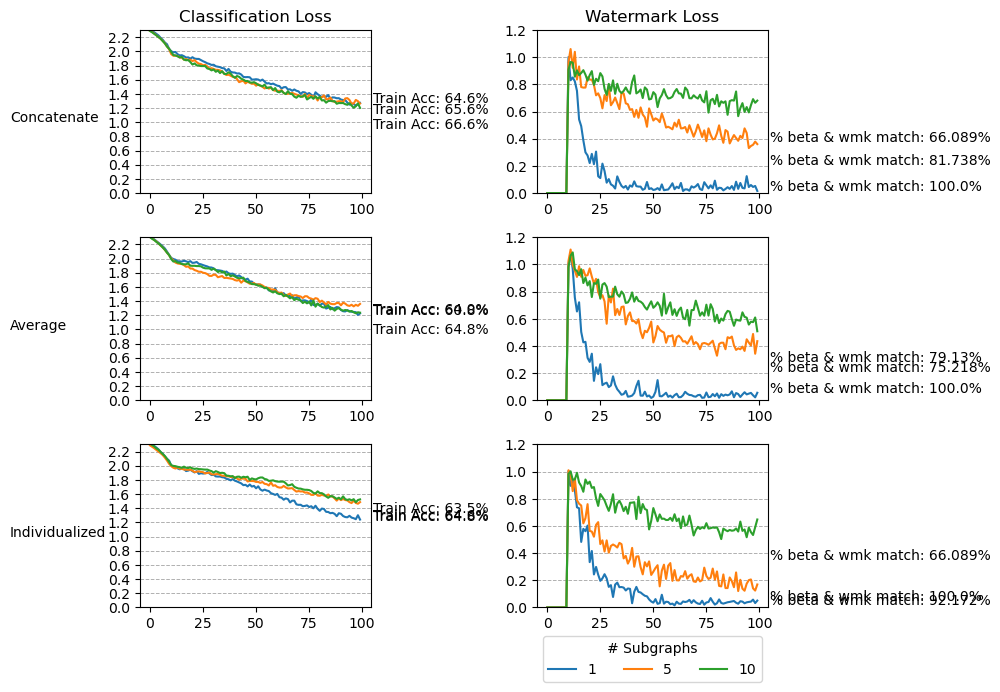

In [250]:
loss_curves_0 = []
loss_curves_1 = []
loss_curves_2 = []

all_vals = []
for n in d2_configs:
    # val = np.round(get_num_subgs(n),3)
    val = get_num_subgs(n)
    all_vals.append(val)
    p_match = dicts_[0][n]['percent_match']
    train_acc = dicts_[0][n]['train acc']
    l_prim = dicts_[0][n]['loss_primary']
    l_wmk = dicts_[0][n]['loss_watermark']
    loss_curves_0.append((val, p_match, train_acc, l_prim,l_wmk))
for n in d2_configs:
    # val = np.round(get_num_subgs(n),3)
    val = get_num_subgs(n)
    all_vals.append(val)
    p_match = dicts_[1][n]['percent_match']
    train_acc = dicts_[1][n]['train acc']
    l_prim = dicts_[1][n]['loss_primary']
    l_wmk = dicts_[1][n]['loss_watermark']
    loss_curves_1.append((val, p_match, train_acc, l_prim,l_wmk))
for n in d2_configs:
    # val = np.round(get_num_subgs(n),3)
    val = get_num_subgs(n)
    all_vals.append(val)
    p_match = dicts_[2][n]['percent_match']
    train_acc = dicts_[2][n]['train acc']
    l_prim = dicts_[2][n]['loss_primary']
    l_wmk = dicts_[2][n]['loss_watermark']
    loss_curves_2.append((val, p_match, train_acc, l_prim,l_wmk))
# for n in d2_configs:
#     # val = np.round(get_num_subgs(n),3)
#     val = get_num_subgs(n)
#     all_vals.append(val)
#     p_match = dicts_[2][n]['percent_match']
#     train_acc = dicts_[2][n]['train acc']
#     p_matches.append(p_match)
#     train_accs.append(train_acc)
#     l_prim = dicts_[2][n]['loss_primary']
#     l_wmk = dicts_[2][n]['loss_watermark']
#     loss_curves_2.append((val,l_prim,l_wmk))
# for n in d2_configs:
#     # val = np.round(get_num_subgs(n),3)
#     val = get_num_subgs(n)
#     all_vals.append(val)
#     p_match = dicts_[3][n]['percent_match']
#     train_acc = dicts_[3][n]['train acc']
#     p_matches.append(p_match)
#     train_accs.append(train_acc)
#     l_prim = dicts_[3][n]['loss_primary']
#     l_wmk = dicts_[3][n]['loss_watermark']
#     loss_curves_3.append((val,l_prim,l_wmk))

# 
loss_curves_0 = sorted(loss_curves_0, key=lambda item: item[0])
loss_curves_1 = sorted(loss_curves_1, key=lambda item: item[0])
loss_curves_2 = sorted(loss_curves_2, key=lambda item: item[0])
# loss_curves_3 = sorted(loss_curves_3, key=lambda item: item[0])


fig,axs = plt.subplots(3,2,figsize=(11,7))
axs[0][0].set_title('Classification Loss')
axs[0][1].set_title('Watermark Loss')
for i, loss_curve_set in enumerate([loss_curves_0, loss_curves_1, loss_curves_2]):#, loss_curves_2, loss_curves_3]):
    axs[i][0].text(-66,1,f"{labels[i]}")
    for j, (val, p_match, train_acc, l_prim, l_wmk) in enumerate(loss_curve_set):
        axs[i][0].plot(range(len(l_prim)),l_prim)
        axs[i][1].plot(range(len(l_wmk)),l_wmk,label=val)
        axs[i][0].set_ylim(0,2.3)
        axs[i][1].set_ylim(0,1.2)
        y0= l_prim[-1]
        y1= l_wmk[-1]
        axs[i][0].text(105,y0-0.15*j,f'Train Acc: {np.round(100*train_acc,3)}%')
        axs[i][1].text(105,y1-0.15*j,f'% beta & wmk match: {np.round(p_match,3)}%')
        if i==2:
            axs[i][1].legend(ncol=len(loss_curve_set),loc='lower center',bbox_to_anchor=(0.5,-0.5))
            axs[i][1].get_legend().set_title("# Subgraphs")


        # Enable grid lines for each subplot
        axs[i][0].grid(axis='y', which='major', linestyle='--', linewidth=0.7)
        axs[i][1].grid(axis='y', which='major', linestyle='--', linewidth=0.7)

        # Increase the frequency of the grid lines
        axs[i][0].yaxis.set_major_locator(plt.MultipleLocator(0.2))
        axs[i][1].yaxis.set_major_locator(plt.MultipleLocator(0.2))

        # axs[i][0].grid(axis='y')
# plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [9]:


config_names = list(set.intersection(*[set(d.keys()) for d in dicts_]))

for dict_ in dicts_:
    print('*****')
    dict_ = {k:dict_[k] for k in config_names}
    sorted_keys = dict(sorted(dict_.items(), key=lambda item: np.mean([
                                                                        item[1]['percent_match'],
                                                                      # 100*item[1]['train acc']
                                                                        ]))).keys()
    for k in list(sorted_keys)[-10:]:
        print(k)
        print(
                'match:',dict_[k]['percent_match'],
              #  'acc:',dict_[k]['train acc'].item()
                )
        print()



*****
watermark coefficient=1, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 10, 5 subgraphs
match: 68.696

watermark coefficient=0.5, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 10, 5 subgraphs
match: 68.69800000000001

watermark coefficient=1, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 5, 10 subgraphs
match: 70.436

watermark coefficient=2, watermark bottom 10-th percentile, subgraph fraction=0.06, watermark after 5, 5 subgraphs
match: 70.78999999999999

watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 50, 5 subgraphs
match: 71.308

watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 5, 10 subgraphs
match: 72.607

watermark coefficient=1, watermark bottom 3-th percentile, subgraph fraction=0.06, watermark after 50, 5 subgraphs
match: 74.78399999999999

watermark coefficient=2, watermark bottom 3-th pe

In [254]:
0.02/5

0.004

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


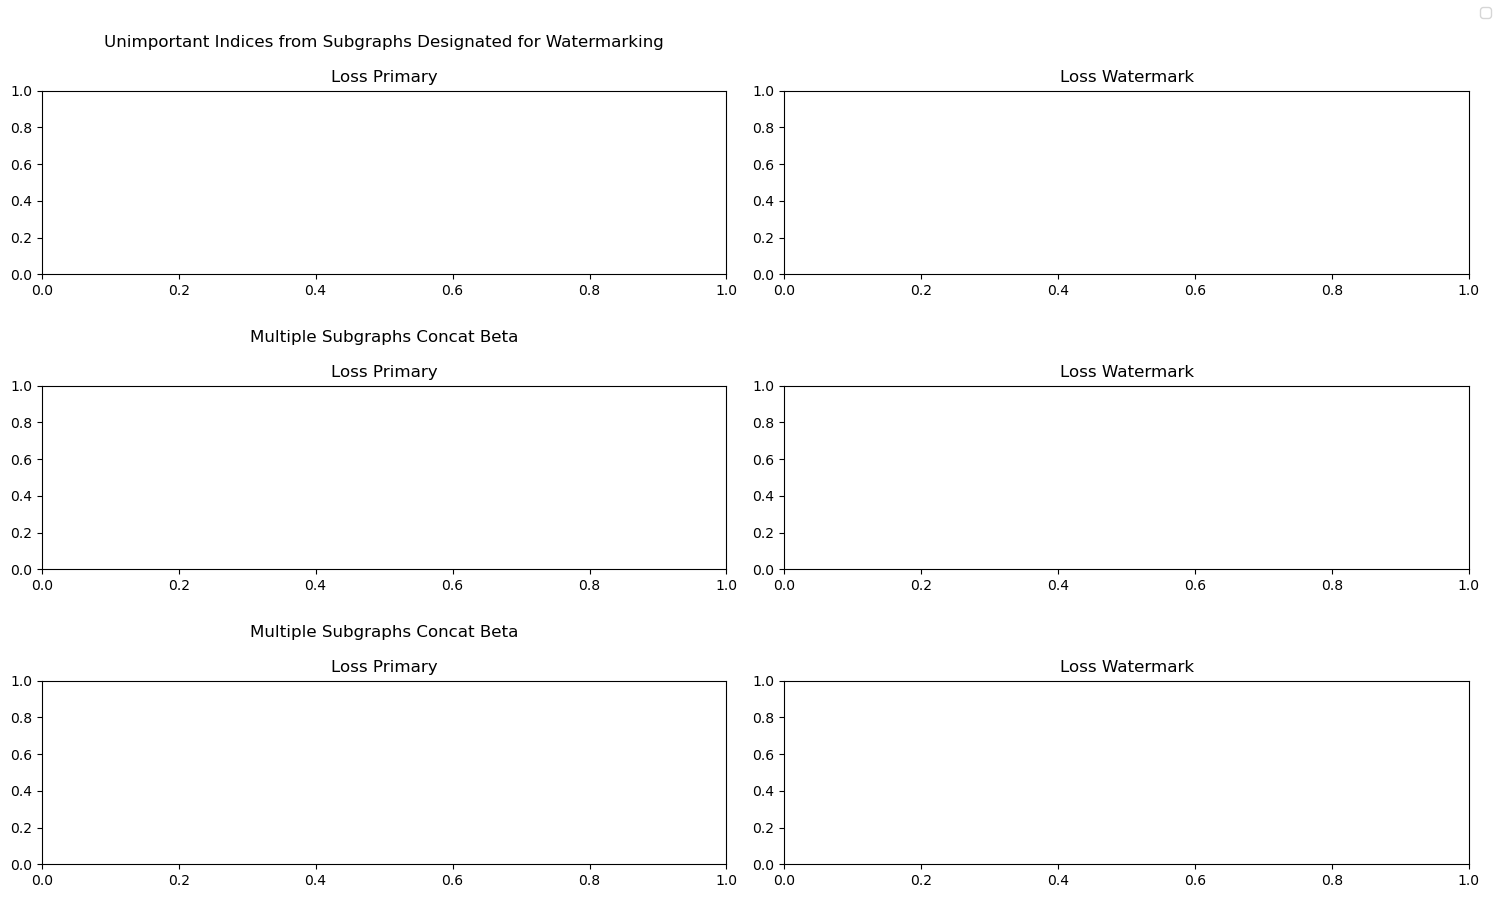

In [134]:



these_names = [n for n in config_names if 
                    get_coef_wmk(n)==0.5 \
                       and 
                    # get_frac(n)==0.02 \
                        # and \
                    # get_num_subgs(n)==10 \
                        # and 
                    get_frac(n)/get_num_subgs(n)>0.001 and get_frac(n)/get_num_subgs(n)<0.005
                        and
                    get_clf_epochs(n)==5 \
                        and
                    get_percentile(n)==3 \
                ]

fig,axs = plt.subplots(len(compare_dict_indices),2,figsize=(15,9))
for i in range(len(compare_dict_indices)):
    axs[i][0].set_title('\n' + row_titles[i] + '\n\nLoss Primary'); axs[i][1].set_title('Loss Watermark')
    for n in these_names:
        loss = dicts_[i][n]['loss']
        loss_primary = dicts_[i][n]['loss_primary']
        loss_watermark = dicts_[i][n]['loss_watermark']
        variable_fn = get_num_subgs
        axs[i][0].plot(range(len(loss_primary)),loss_primary)
        axs[i][0].set_ylim(0.5,1.5)
        axs[i][1].plot(range(len(loss_watermark)),loss_watermark, label=f'{labels[i]}, {variable_fn(n)}: {np.round(100*dicts_[i][n]["train acc"],3)} acc, {dicts_[i][n]["percent_match"]} match')
        axs[i][1].set_ylim(-0.2,1.4)


# these_names = [n for n in config_names if 
#                     get_coef_wmk(n)==2 \
#                         and 
#                     get_frac(n)==0.02 \
#                         and
#                     get_num_subgs(n)==5 \
#                         and 
#                     get_clf_epochs(n)==5 \
#                         and
#                     get_percentile(n)==3 
#                 ]

# fig,axs = plt.subplots(1,3,figsize=(15,4))
# for n in these_names:
#     axs[0].set_title('Loss'); axs[1].set_title('Loss Primary'); axs[2].set_title('Loss Watermark')
#     for i in range(2):
#         loss = dicts_[i][n]['loss']
#         loss_primary = dicts_[i][n]['loss_primary']
#         loss_watermark = dicts_[i][n]['loss_watermark']
#         axs[0].plot(range(len(loss)),loss)
#         axs[0].set_ylim(0,4.6)
#         axs[1].plot(range(len(loss_primary)),loss_primary, label=f'{labels[i]}: {np.round(100*dicts_[i][n]["train acc"],3)} acc, {dicts_[i][n]["percent_match"]} match')
#         axs[1].set_ylim(0,2.4)
#         axs[2].plot(range(len(loss_watermark)),loss_watermark)
#         axs[2].set_ylim(-0.2,1.4)

fig.legend()
plt.tight_layout()
plt.show()

watermark coefficient=0.5, watermark bottom 10-th percentile, subgraph fraction=0.001, watermark after 5



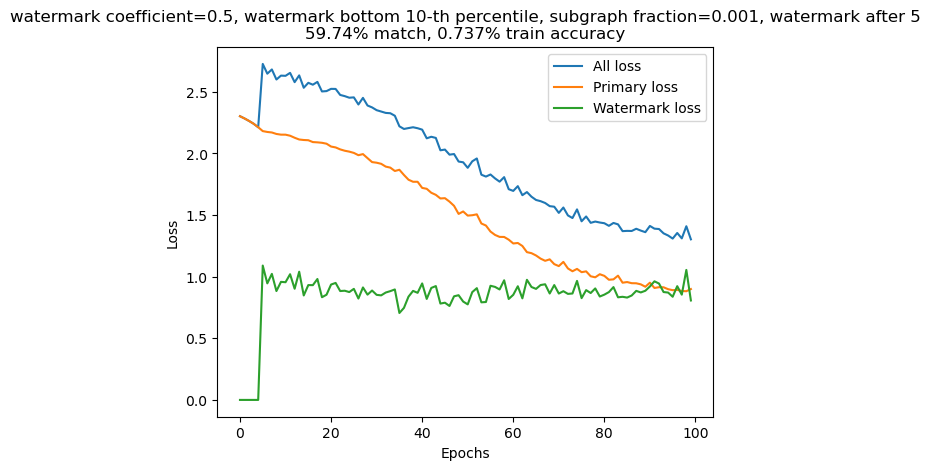

In [28]:

name = list(compare_dict.keys())[27]
print(name)
compare_dict[name].keys()
all_loss_curve          = compare_dict[name]['loss']
primary_loss_curve      = compare_dict[name]['loss_primary']
watermark_loss_curve    = compare_dict[name]['loss_watermark']
percent_match           = compare_dict[name]['percent_match']
train_acc               = compare_dict[name]['train acc']



print()
plt.plot(range(len(all_loss_curve)), all_loss_curve, label='All loss')
plt.plot(range(len(primary_loss_curve)), primary_loss_curve, label='Primary loss')
plt.plot(range(len(watermark_loss_curve)), watermark_loss_curve, label='Watermark loss')
plt.title(name + f'\n{percent_match}% match, {train_acc}% train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

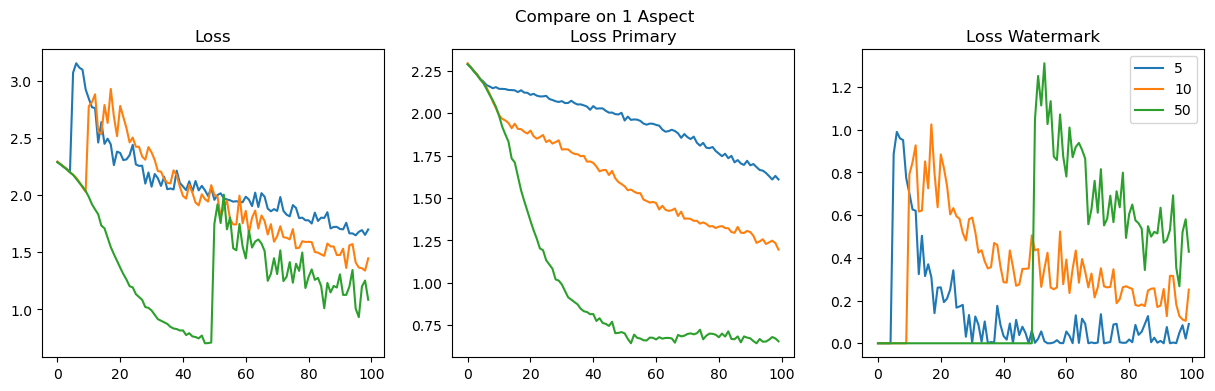

In [37]:
get_coef_wmk    = lambda name: float(name.split(' ')[1].split('=')[-1][:-1])
get_percentile  = lambda name: int(name.split(' ')[4].split('-')[0])
get_frac        = lambda name: float(name.split(' ')[7].split('=')[-1][:-1])
get_clf_epochs  = lambda name: int(name.split(' ')[-1])

these_names = [n for n in compare_dict.keys() if 
                                  get_coef_wmk(n)==1 \
                                    and 
                                  get_frac(n)==0.01 \
                                    and 
                                #   get_clf_epochs(n)==5 \
                                    # and
                                  get_percentile(n)==3
                                  ]


fig,axs = plt.subplots(1,3,figsize=(15,4))
fig.suptitle('Compare on 1 Aspect')
axs[0].set_title('Loss'); axs[1].set_title('Loss Primary'); axs[2].set_title('Loss Watermark')
for n in these_names:
    loss = compare_dict[n]['loss']
    loss_primary = compare_dict[n]['loss_primary']
    loss_watermark = compare_dict[n]['loss_watermark']

    variable_fn = get_clf_epochs

    axs[0].plot(range(len(loss)),loss, label=variable_fn(n))
    axs[1].plot(range(len(loss_primary)),loss_primary, label=variable_fn(n))
    axs[2].plot(range(len(loss_watermark)),loss_watermark, label=variable_fn(n))
plt.legend()
plt.show()

In [32]:
sorted_keys = dict(sorted(compare_dict.items(), key=lambda item: np.mean([item[1]['percent_match'],100*item[1]['train acc']]))).keys()
for k in sorted_keys:
    print(k)
    print('match:',compare_dict[k]['percent_match'],'acc:',compare_dict[k]['train acc'].item())
    print()

watermark coefficient=2, watermark bottom 50-th percentile, subgraph fraction=0.001, watermark after 5
match: 54.31 acc: 0.508

watermark coefficient=2, watermark bottom 100-th percentile, subgraph fraction=0.005, watermark after 5
match: 56.27 acc: 0.508

watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.005, watermark after 5
match: 73.91 acc: 0.357

watermark coefficient=2, watermark bottom 50-th percentile, subgraph fraction=0.005, watermark after 5
match: 63.45 acc: 0.518

watermark coefficient=2, watermark bottom 100-th percentile, subgraph fraction=0.01, watermark after 5
match: 63.32 acc: 0.546

watermark coefficient=1, watermark bottom 10-th percentile, subgraph fraction=0.001, watermark after 5
match: 61.04 acc: 0.573

watermark coefficient=0.5, watermark bottom 3-th percentile, subgraph fraction=0.005, watermark after 5
match: 65.22 acc: 0.577

watermark coefficient=2, watermark bottom 3-th percentile, subgraph fraction=0.001, watermark after 10


In [ ]:
def regress_on_subgraph(data, nodeIndices, probas):
    x_this_sub = data.x[nodeIndices]
    y_this_sub = probas[nodeIndices]
    beta_this_sub = solve_regression(x_this_sub, y_this_sub)
    return beta_this_sub

def select_indices_of_present_features(current_indices, num_indices, zero_features):
    indices = []
    # num_unimportant_indices = int(0.01*watermark_kwargs['unimportant_percentile']*data.x.shape[1])
    while len(indices)<num_indices:
        if current_indices[i] not in zero_features:
            indices.append(current_indices[i])
        i +=1 
    return indices

num_indices = int(0.01*watermark_kwargs['unimportant_percentile']*data.x.shape[1])
num_subgraphs = len(subgraph_dict)
features_all_subgraphs = torch.vstack([subgraph_dict[subgraph_central_node]['subgraph'].x for subgraph_central_node in subgraph_dict.keys()]).squeeze()
zero_features_across_subgraphs = torch.where(torch.sum(features_all_subgraphs, dim=0) == 0)[0]

personalized_indices=False
index_selection_method = 'random'

if num_subgraphs>=1 and index_selection_method=='random':
    ''' Shuffles all feature indices and selects a fixed number of non-zero features for all subgraphs uniformly '''
    shuffled_indices = torch.randperm(data.x.shape[1])
    indices = select_indices_of_present_features(shuffled_indices, num_indices, zero_features_across_subgraphs)
    all_indices = [indices]*len(subgraph_dict)

if (num_subgraphs==1 or (num_subgraphs>1 and personalized_indices==False and merge_betas_method=='concat')) and index_selection_method=='unimportant':
    ''' Uses concatenated subgraph nodes for regression, sorts features by overall importance, and selects unimportant features uniformly for all subgraphs '''
    all_indices = torch.concat([subgraph_dict[k]['nodeIndices'] for k in subgraph_dict.keys()])
    beta_all_sub = regress_on_subgraph(data, all_indices, probas)
    sorted_indices = sorted(range(data.x.shape[1]), key=lambda item: beta_all_sub.abs()[item])
    indices = select_indices_of_present_features(sorted_indices, num_indices, zero_features_across_subgraphs)
    all_indices = [indices]*len(subgraph_dict)

if num_subgraphs>1 and personalized_indices==False and merge_betas_method=='average' and index_selection_method=='unimportant':
    ''' Computes and averages regression coefficients across subgraphs, sorts features by overall importance, and selects unimportant features uniformly for all subgraphs '''
    betas = []
    for subgraph_sig in subgraph_dict.keys():
        beta_this_sub = regress_on_subgraph(data, subgraph_dict[subgraph_sig]['nodeIndices'], probas)
        betas.append(beta_this_sub)
    betas_avg = torch.mean(torch.vstack(betas),dim=0)
    sorted_indices = sorted(range(data.x.shape[1]), key=lambda item: betas_avg.abs()[item])
    indices = select_indices_of_present_features(sorted_indices, num_indices, zero_features_across_subgraphs)
    all_indices = [indices]*len(subgraph_dict)

if num_subgraphs>1 and personalized_indices==True and index_selection_method=='unimportant':
    ''' Computes regression coefficients for each subgraph individually, sorts features by importance for each subgraph, and selects unimportant features uniquely for each subgraph '''
    all_indices = []
    for subgraph_sig in subgraph_dict.keys():
        nodeIndices = subgraph_dict[subgraph_sig]['nodeIndices']
        beta_this_sub = regress_on_subgraph(data, nodeIndices, probas)
        sorted_indices = sorted(range(data.x.shape[1]), key=lambda item: beta_this_sub.abs()[item])
        zero_features_this_subgraph = torch.where(torch.sum(data.x[nodeIndices], dim=0) == 0)[0]
        indices = select_indices_of_present_features(sorted_indices, num_indices, zero_features_this_subgraph)
        all_indices.append(indices)



